In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM

In [2]:
base = pd.read_csv('PETR4_SA_treinamento.csv')

In [3]:
base = base.dropna()
base_treino = base.iloc[:, 1:2].values

In [4]:
base

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-26,10.870000,10.88,10.210000,10.320000,9.573892,27059500.0
1,2014-12-29,10.150000,10.54,10.060000,10.280000,9.536783,24392000.0
2,2014-12-30,10.160000,10.35,10.010000,10.030000,9.304857,27623700.0
3,2015-01-02,9.990000,9.99,9.350000,9.360000,8.683293,49559500.0
4,2015-01-05,9.140000,9.19,8.530000,8.560000,7.941135,78385100.0
...,...,...,...,...,...,...,...
1238,2019-12-17,29.639999,29.90,29.430000,29.850000,29.440350,40679900.0
1239,2019-12-18,29.750000,30.57,29.700001,30.540001,30.120882,64201600.0
1240,2019-12-19,30.450001,30.75,30.420000,30.610001,30.189920,39696000.0
1241,2019-12-20,30.600000,30.60,30.020000,30.260000,29.844723,93064900.0


In [5]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treino_normalizado = normalizador.fit_transform(base_treino)

In [6]:
previsores = []
preco_real = []

for i in range(90, 1241):
    previsores.append(base_treino_normalizado[i-90:i,0])
    preco_real.append(base_treino_normalizado[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores,(previsores.shape[0], previsores.shape[1],1))

In [7]:
regressor = Sequential()
regressor.add(LSTM(units=100,
return_sequences=True,
input_shape = (previsores.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50,
return_sequences=True,))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1,
activation='linear'))

In [8]:
regressor.compile(optimizer='rmsprop',
loss='mean_squared_error',
metrics=['mean_squared_error'])
regressor.fit(previsores,
preco_real,
epochs=100,
batch_size=32)

Epoch 1/100
36/36 [==============================] - 13s 142ms/step - loss: 0.0631 - mean_squared_error: 0.0631
Epoch 2/100
36/36 [==============================] - 5s 138ms/step - loss: 0.0191 - mean_squared_error: 0.0191
Epoch 3/100
36/36 [==============================] - 5s 141ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 4/100
36/36 [==============================] - 5s 138ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 5/100
36/36 [==============================] - 5s 138ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 6/100
36/36 [==============================] - 5s 137ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 7/100
36/36 [==============================] - 5s 135ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 8/100
36/36 [==============================] - 5s 128ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 9/100
36/36 [==============================] - 5s 147ms/step - loss: 0.0064 - mean_squared_error: 0.0064


In [18]:
base_teste = pd.read_csv('PETR4_SA_teste.csv')
base_teste = base_teste.dropna()
preco_real_teste = base_teste.iloc[:, 1:2].values
base_completa = pd.concat((base['Open'], base_teste['Open']), axis=0)

In [19]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1,1)
entradas = normalizador.transform(entradas)

In [20]:
previsores_teste = []
for j in range(90,338):
    previsores_teste.append(entradas[j-90:j, 0])
previsores_teste = np.array(previsores_teste)
previsores_teste = np.reshape(previsores_teste,
(previsores_teste.shape[0],
previsores_teste.shape[1],
1))
previsores_teste = regressor.predict(previsores_teste)
previsores_teste = normalizador.inverse_transform(previsores_teste)

In [21]:
previsores_teste.mean()
preco_real_teste.mean()

22.347611372469636

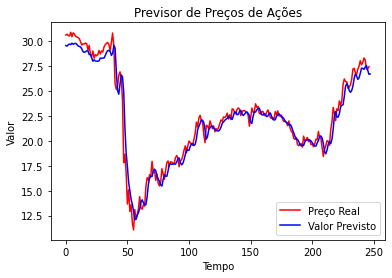

In [24]:
import matplotlib.pyplot as plt
plt.plot(preco_real_teste,
color='red',
label='Preço Real')
plt.plot(previsores_teste,
color='blue',
label='Valor Previsto')
plt.title('Previsor de Preços de Ações')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()